<figure>
    <img src="thumbnail.jpg"
        alt="thumbnail"
        class="post-thumbnail">
    <figcaption>Created by Microsoft Designer</figcaption>
</figure>

In this post, let's build an image classifier to classify paintings made by Picasso and Monet. I am currently doing [Practical Deep Learning for Coders](https://course.fast.ai/) course by fastai and this blog post is to summarize my takeways.

## Install packages

Let's start by installing the required `python` packages.

```bash
pip install -Uqq fastai # <1>
pip install -Uqq duckduckgo_search # <2>
```

1. Installs `fastai` library to build and train deep learning models. It also provides utility methods to download images.
2. Installs `duckduckgo_search` library to search for images programatically.

## Import packages

In [26]:
import random
from duckduckgo_search import DDGS
from time import sleep
from fastai.vision.all import *

## Image Search using DuckDuckGo Search

In [5]:
ddgs = DDGS()
search_term = 'picasso painting'
results = ddgs.images(search_term, max_results=1)

The `ddgs.images(search_term, max_results=1)` method uses DuckDuckGo image search engine to search for images with keyword `picasso painting` and returns the search results. The number of results returned can be controlled by `max_results`

In [6]:
results

[{'title': 'Woman s head and self portrait 1929 Picasso - United Kingdom',
  'image': 'https://cdn11.bigcommerce.com/s-5qm28d53av/images/stencil/2560w/products/330/9318/Woman-s-head-and-self-portrait-1929-Picasso__04078.1586802926.jpg?c=1',
  'thumbnail': 'https://tse2.mm.bing.net/th?id=OIP.ZCBc3r5pHCQkUXAesuRWtAHaJf&pid=Api',
  'url': 'https://my-poster.com/Woman-s-head-and-self-portrait-1929-Picasso-/',
  'height': 3282,
  'width': 2560,
  'source': 'Bing'}]

The search results returned by the above method is a list of dictionaries. In the dictionary, the value with key as `image` is the url containing the image to be downloaded. Let's use that to download the image using `fastai`'s `download_images` method.

## Download images

In [7]:
url = results[0]['image']
path = Path('images') # <1>
path.mkdir(exist_ok=True) # <2>
download_images(path, urls=[url]) # <3>

1. Initialize `Path` object to point to the directory for downloading images.
2. Creates a directory pointed by `path`. `exist_ok=True` supress the error if directory already exists.
3. Downloads the images from the list of urls passed as `urls` and saves in the folder pointed by `path`.

Let's find the image path and display the image. `ls` method lists all the contents of the `Path` object.

In [8]:
path.ls()

(#1) [Path('images/c72d6b91-3379-44f9-8878-92cdf7b87d3c.jpg')]

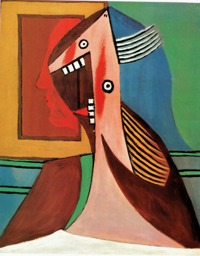

In [10]:
im = Image.open('images/c72d6b91-3379-44f9-8878-92cdf7b87d3c.jpg')
im.to_thumb(256) # <1>

1. Creates thumbnail version of the image, no larger than the given size. Here it's 256px.

## Download dataset

Now let's wrap the above logics to functions and download the dataset for our Picasso and Monet painting classifier.

In [11]:
def search_images(search_term: str, max_images:int=30):
    print(f"Searching for '{search_term}'")
    ddgs = DDGS()
    results = ddgs.images(search_term, max_results=max_images)
    return L(results).itemgot('image') # <1>

1. extracts all the `image` attribute from the dictionaries and returns as a list

In [15]:
searches = 'picasso painting', 'monet painting' # <1>
path = Path('painting') # <2>

for o in searches:
    dest = path/o
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest,
                    urls=search_images(f'{o} photo', max_images=100))
    sleep(10) # <3>
    resize_images(path/o, max_size=400, dest=path/o) # <4>

Searching for 'picasso painting photo'
Searching for 'monet painting photo'


1. Keywords used to search for images.
2. Root folder path to save the downloaded images.
3. Pause for 10 seconds between each request to the image search API.
4. Resize all image files inside `path/o` to `max_size`.

### Delete corrupted images

Sometimes the downloaded images may not be in right format or got corrupted. It's good to find and delete those files before training the model. fastai provides the utility function `verify_images` which does this for us.

In [16]:
fns = get_image_files(path) # <1>
failed = verify_images(fns) # <2>
failed.map(Path.unlink) # <3>
print(f"corrupted images: {len(failed)}")

corrupted images: 3


1. Returns all the image file paths in `path` directory.
2. Verifies and returns list of image file paths which are corrupted.
3. On each corrupted `path` object, apply `Path.unlink` method which deletes the file.

## Dataloaders

Before we train the model we should do some datapreprocessing like resizing the images, creating labels for each image file etc., All these can be done through `DataBlock` and `DataLoaders`.

In [ ]:
db = DataBlock( # <1>
    blocks=(ImageBlock, CategoryBlock), # <2>
    get_items=get_image_files, # <3>
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # <4>
    get_y=parent_label, # <5>
    item_tfms=[Resize(192, method='squish')] # <6>
)

1. `DataBlock` is the class used to write the blueprint of our dataset.
2. What are the input (independent variable) and output (dependent variable) data types? `ImageBlock` tells the input variable in our dataset represents **Image** datatype and `CategoryBlock` tells the output variable in our dataset represents **Category** datatype (classification task).
3. How do we extract individual items of our dataset? `get_image_files` is a function which takes root folder path as input and returns all the image files as output.
4. How to split the dataset into train and validation sets? `RandomSplitter` is one of the splitting strategies. It splits the dataset randomly. `valid_pct=0.2` tells 20% of the dataset should be part of validation set. `seed=42` is used for reproducibility.
5. How to create label (`y`) for each input sample in our dataset? `parent_label` is a function which extracts the parent folder name of the file and returns as output.
6. Any transformations to be applied on each item of the dataset? Usually when we train the model, we won't be training one image at a time but a batch of images. To make this convenient, we make sure all the images are of same size. `Resize` method is used to resize the image to specified size. Here it's `192`. While resizing, the image may be cropped/squished/anything else. Here, we are asking to `squish` the image.

The above code serves as a blueprint of our dataset. But for training the model, we actually need the training and validation dataset created from the downloaded images with all the inputs and outputs in the right format as mentioned in the blueprint. `DataLoaders` exactly does that.

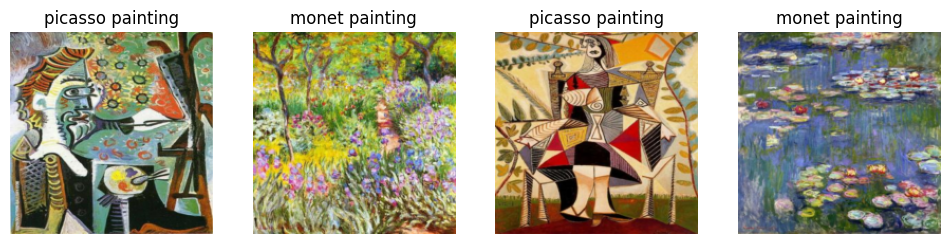

In [22]:
dls = db.dataloaders(path, bs=32) # <1>
dls.train.show_batch(max_n=4, nrows=1) # <2>

1. Creates dataloaders from the `Datablock`. Inputs are `path` and `bs`. `path` is used to point to the downloaded dataset path from which all the files are read by the `get_image_files` function used in datablock definition. `bs` is the batch size which ensures during model training the model gets `bs` # of images at a time rather just 1. This is done to make efficient use of GPUs as well as other advantages.
2. Once the dataloaders is created, we can access the training and validation set using `train` and `valid` attributes respectively. The `dls.train.show_batch` displays 4 images from the training set in a single row which is set by `max_n` and `nrows`. 

## Training
Now we have the dataset ready, let's train the model to classify Picasso and Monet images. For this project, rather than training a deep learning model from scratch let's use a pretrained model called `resnet18` and finetune it for the task (Picasso and Monet classification) at hand.

In fastai, most of the trainer has a common api which is `domain_learner`. Since we are going to solve a **Computer Vision** problem, we'll be using `vision_learner`. We will be passing the dataset, pretrained deep learning model and metrics (to log) as inputs. We'll train the model using `finetune` method.

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate) # <1>
learn.fine_tune(5)  # <2>

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.467476,0.218055,0.054795,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.083487,0.011494,0.000000,00:01
1,0.076097,0.001811,0.000000,00:01
2,0.058125,0.001642,0.000000,00:01
3,0.043209,0.002014,0.000000,00:01
4,0.032918,0.002884,0.000000,00:01


1. `dls` is the dataloaders we created in previous setps. `resnet18` is the Residual Network architecture with 18 layers pre-trained on Imagenet dataset. `error_rate` is the percentage of validation examples the model predicts wrong.
2. `fine_tune` finetunes the model for the new dataset at hand for given number of epochs. It also prints the training progress.

We can see that the validation error is around 0. It means the model does pretty good job in differentiating Picasso and Monet paintings.

::: {.callout-note}
The original model was pretrained on a different dataset for a different problem. For our project, we need to predict which class a painting belongs to. We have **two classes**. So the output layer of the model should be replaced with two nodes. This is automatically taken care by fastai. The number **5** represents the number of epochs the model should be trained for. When a model sees all the training sample once, we call it an epoch.

The `finetune` method also employes best practices while training the model. We can see there are two sections in the training log. The second section represents the 5 epochs which we requested fastai to train for. In those 5 epochs, all the layers are trained and the metrics are logged. So then what is the first section of log which shows additional epoch? The first section shows the training log of one epoch done by fastai by freezing (no training) all the layers expect the last layer which was inserted newly for our task.
:::

::: {.callout-note}
An epoch is nothing but single pass of all the samples in the training dataset by the model.
:::

## Prediction

Now we have our trained model, let's make a prediction using the `predict` method.

In [27]:
fns = get_image_files(Path('painting'))

('monet painting', tensor(0), tensor([1.0000e+00, 1.8999e-08]))


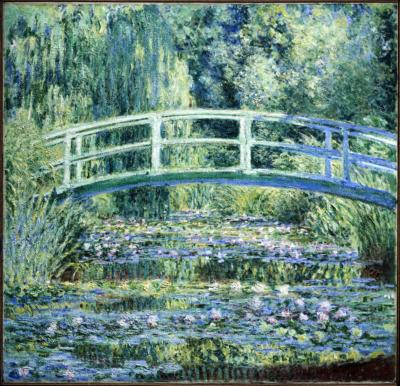

In [32]:
fn = random.choice(fns) # <1>
preds = learn.predict(fn) # <2>
print(preds)

Image.open(fn)

1. Randomly chooses an image file from the list of images.
2. `predict` method is used to make a prediction using the trained model `learn`.

The model predicts the output as 'monet painting' and it's 100% confident about it!

The predicted output is a tuple containing three values. They are **(*predicted label*, *predicted label as index*, *class probabilities for each class*)**. The index corresponding to maximum class probability is chosen as the predicted class and corresponding index is returned in the second value of the tuple. Now we have the class index, how to find the class label? `learn.dls.vocab` or `dls.vocab` can be used to see the list of labels and the order used by fastai.

In [33]:
learn.dls.vocab # <1>

['monet painting', 'picasso painting']

Here, the $0^{th}$ index represents 'monet painting'. Hence, the first value of the tuple returned by the `predict` method has 'monet painting' in it.

## Save the model

Now we have our trained model, we can use this in other apps. To do so, first we need to save the model so we need not retrain. In fastai, the model can be saved to a file using the `export` method.

In [24]:
learn.export('model.pkl') # <1>

1. Export (save) the trained model in the given path.

I deployed the above model as a web app where a user can upload images of Picasso and Monet paintings and get predictions. You can find it [here](https://harishb00-painting-classifier.hf.space/). In future posts, I will share how I did it.

<figure>
    <img src="painting-gradio-thumbnail.png"
        alt="thumbnail"
        class="post-thumbnail">
    <figcaption>App deployed in HuggingFace Spaces</figcaption>
</figure>

That's it for today. See you in another post.